In [56]:
%reload_ext autoreload
%autoreload 2
import torch
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import transforms
import torchvision
import copy
from exitai.learner import Learner
from exitai.const import LR_TRACKER

%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(1)

In [25]:
class TempDataSet(Dataset):
    def __getitem__(self, index):
        return torch.tensor([1.,0.]), 1
    def __len__(self):
        return 3
temp_data_set = TempDataSet()
data_loader_train = DataLoader(temp_data_set, 2, shuffle=True, num_workers=8)
data_loader_test = DataLoader(temp_data_set, 2, shuffle=True, num_workers=8)

In [33]:
criterion = F.cross_entropy
model = nn.Linear(2, 2)

### 1. lr_find

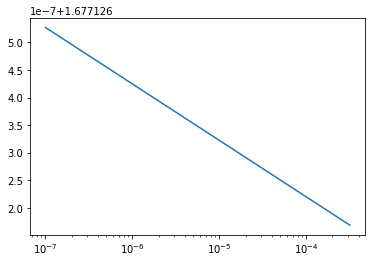

In [34]:
learner = Learner(data_loader_train, data_loader_test, model, criterion)
learner.lr_find(start_lr=1e-7, end_lr=1, num_it=2, num_batch=1)

### 2. fit

#### 2.1 LR Cos Annealing + multi layer LR

LRTracker True
---- epoch:0 ------
   [train] Average loss: 39.0021, acc: 33.33%
   [test] Average loss: 9.5907, acc: 100.00%
---- epoch:1 ------
   [train] Average loss: 7.2666, acc: 100.00%
   [test] Average loss: 3.9807, acc: 100.00%
---- epoch:2 ------
   [train] Average loss: 2.3164, acc: 100.00%
   [test] Average loss: 0.0784, acc: 100.00%
---- epoch:3 ------
   [train] Average loss: 0.0442, acc: 100.00%
   [test] Average loss: 0.0019, acc: 100.00%
---- epoch:4 ------
   [train] Average loss: 0.0012, acc: 100.00%
   [test] Average loss: 0.0003, acc: 100.00%
---- epoch:5 ------
   [train] Average loss: 0.0003, acc: 100.00%
   [test] Average loss: 0.0002, acc: 100.00%
---- epoch:6 ------
   [train] Average loss: 0.0001, acc: 100.00%
   [test] Average loss: 0.0000, acc: 100.00%
---- epoch:7 ------
   [train] Average loss: 0.0000, acc: 100.00%
   [test] Average loss: 0.0000, acc: 100.00%
---- epoch:8 ------
   [train] Average loss: 0.0000, acc: 100.00%
   [test] Average loss: 0.0000,

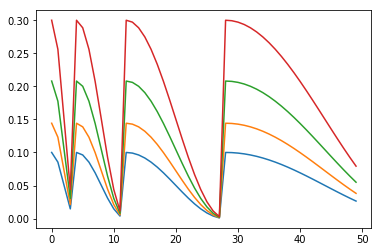

In [79]:
model = nn.Sequential(
    nn.Linear(2, 2), 
    nn.Linear(2, 2),
    nn.Linear(2, 2),
    nn.Linear(2, 2),
)
learner = Learner(data_loader_train, data_loader_test, model, criterion)
learner.fit([0.1, 0.3], callbacks=LR_TRACKER)

#### 2.2 static LR

LRTracker True
---- epoch:0 ------
   [train] Average loss: 0.0000, acc: 100.00%
   [test] Average loss: 0.0000, acc: 100.00%
---- epoch:1 ------
   [train] Average loss: 0.0000, acc: 100.00%
   [test] Average loss: 0.0000, acc: 100.00%


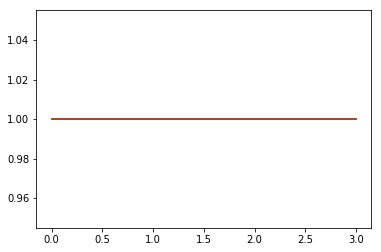

In [82]:
learner.fit(1, num_epochs=2, cycle=None, callbacks=LR_TRACKER)

#### 2.3 no callbacks

In [83]:
learner.fit(1, num_epochs=2)

---- epoch:0 ------
   [train] Average loss: 0.0000, acc: 100.00%
   [test] Average loss: 0.0000, acc: 100.00%
---- epoch:1 ------
   [train] Average loss: 0.0000, acc: 100.00%
   [test] Average loss: 0.0000, acc: 100.00%
